# ACNets: Diagonal Connectivity Classifier

This notebook fits a binary classifier to predict participant's group, AVGP or NVGP, using functional connectivity matrices. As input, it takes upper-triangular connectivity matrices for each participant.

To address the concerns about small sample size and test/train splits, results are evaluated using 5-fold cross-validated permutation testing.

## 0. Setup

In [1]:

import math
import re

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline

import xgboost

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

Last updated: 2022-02-20T11:57:59.396969+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

re        : 2.2.1
numpy     : 1.21.5
matplotlib: 3.5.1
seaborn   : 0.11.2
xarray    : 0.21.1
xgboost   : 1.5.1
sklearn   : 1.0.2
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
pandas    : 1.4.0



/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Load the dataset

In [33]:
atlases = ['dosenbach2007', 'dosenbach2010', 'difumo_64_2', 'difumo_128_2', 'difumo_1024_2']

connectivity_measures = ['tangent', 'precision']

DATASETS = dict()

for atlas in atlases:
  for connectivity in connectivity_measures:
    _conn_key = f'{connectivity}_connectivity'
    ds = xr.open_dataset(f'data/julia2018_resting/connectivity_{atlas}.nc')
    _conn = ds[_conn_key]
    _conn.coords['group'] = ds.group
    _conn['inverse_efficiency_score_ms'] = ds['inverse_efficiency_score_ms']
    DATASETS[f'{atlas}_{connectivity}'] = _conn
    
    if 'difumo_names' in ds.coords:
      _conn.coords['region'] = ds.coords['difumo_names'].values


## 2. Classification Model

-[ ] TODO: replicate https://www.frontiersin.org/articles/10.3389/fnhum.2014.00425/full

In [40]:
# ALT1: single-output classifiers, e.g., SVM, boosting
model = svm.SVC(kernel='rbf', C=1, probability=True)
# model =ensemble.AdaBoostClassifier(model, n_estimators=100, algorithm='SAMME.R')
# model =ensemble.GradientBoostingClassifier(n_estimators=100)

# ALT2: chance level
# model = dummy.DummyClassifier(strategy='uniform')

# ALT3: multi-output (classification + behavioral regression)
# model = multioutput.MultiOutputClassifier(ensemble.GradientBoostingClassifier())

# model = xgboost.XGBClassifier(
#     n_estimators=100, max_depth=10,
#     use_label_encoder=False,
#     eval_metric='auc',
#     n_jobs=-1)

pipe = Pipeline([
    # ('zerovar', feature_selection.VarianceThreshold(.01)),
    # ('select', feature_selection.SelectKBest()),
    # ('rfe', feature_selection.RFE(svc)),
    # ('standard_scaler', preprocessing.StandardScaler()), 
    # ('reducer', UMAP(n_components=3)), 
    # ('reducer', decomposition.PCA()),
    # ('reducer', cross_decomposition.PLSCanonical()),    
    ('model', model),
], verbose=False)

param_grid = {
    # 'zerovar__threshold': [0],
    # 'select__k': np.linspace(1, X.shape[1], num=100, endpoint=True, dtype='int'),
    # 'rfe__n_features_to_select': [.1, .2, .5, 1.],
    # 'reducer__n_neighbors': [1, 2, 3, 4, 5, 10],  # UMAP
    # 'reducer__n_components': [2,3,5],  # UMAP
    # 'reducer__n_components': range(1, 10),  # PCA
    # 'model__n_estimators': [10, 100, 1000],  # XGBClassifier, GradientBoostingClassifier
    # 'model__estimator__n_estimators': [10, 100],  # MultiOutputClassifier
}

grid = model_selection.GridSearchCV(
    pipe, param_grid,
    # cv=model_selection.LeaveOneOut(), scoring='accuracy',
    cv=5, scoring='roc_auc',
    # scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall'], refit='accuracy',
    n_jobs=-1, verbose=1,
)

# rfe_model = feature_selection.RFECV(grid)
# rfe_model.fit()

Now we tune the hyper-parameters and train the model. We then evaluate the fitted model on the held-out test data:

## 1. Hyper-parameter tuning

In [43]:



_tmp_results = []  # will be converted to DataFrame and deleted later

for ds_name, ds in DATASETS.items():
  
  atlas_name = re.findall(r'^(dosenbach20\d{2}|difumo_\d{2,4}_\d).*$',ds_name)[0]
  
  connectivity_measure_name = ds_name.replace(atlas_name + '_', '')

  # 1. input (vectorized connectivity matrix)
  X = np.array([np.diag(subj_conn) for subj_conn in ds.values])

  # 1.1. threshold X
  X_threshold = np.median(X, axis=1) + np.std(X, axis=1)
  X = np.where(np.abs(X) >= X_threshold.reshape(-1,1), X, 0)

  # 2. output (AVGP vs NVGP encoded as integers)
  y_encoder = preprocessing.LabelEncoder()
  y = y_encoder.fit_transform(ds['group'])

  # 2.1. behavioral outputs (inverse efficiency scores in millis)
  y_beh = ds['inverse_efficiency_score_ms'].values

  # 3. remove subjects with missing behavioral data and duplicate scans
  # FIXME: this is a hack, make sure NEW subjects are different from OLD ones
  # subject_labels = xr.concat([ds['subject'], ds['subject'] + 'NEW'], dim='subject')
  # invalid_subjects = subject_labels.to_series().duplicated(keep='first')[32:]
  # invalid_subjects = invalid_subjects | np.isnan(y_beh)
  invalid_subjects = np.isnan(y_beh)
  
  X = X[~invalid_subjects]
  y = y[~invalid_subjects]
  y_beh = y_beh[~invalid_subjects]

  # DEBUG
  print(f'[{ds_name}]\n'
        f'{X.shape[1]} features, {X.shape[0]} subjects, '
        f'{np.unique(y).shape[0]} classes.')
  
  train, test = model_selection.train_test_split(
    range(len(X)),
    test_size=0.2,
    shuffle=True,
    stratify=y)

  # fit
  grid.fit(X[train], y[train])

  # evaluate
  score_train = grid.score(X[train], y[train])
  score_test = grid.score(X[test], y[test])

  # clear_output()

  # report scores and hyperparameters
  print(f'train set score (roc_auc): {score_train:.2f}')
  print(f'test set score (roc_auc): {score_test:.2f}')
  
  print('Permutation testing...', end=' ')
  
  
  cv = model_selection.StratifiedKFold(5)
  #cv=model_selection.LeaveOneOut()

  # we don't have a hyperparameter so we pass 'pipe' instead of 'grid'
  obs_score, perm_scores, p_value = model_selection.permutation_test_score(
    pipe, X, y,
    cv=cv,
    scoring='roc_auc',
    #scoring='accuracy',  # LOO cannot handle roc-auc
    n_permutations=1000,
    n_jobs=-1, verbose=0)

  _tmp_results.append({
    'atlas': atlas_name,
    'randomized': False,
    'connectivity_measure': connectivity_measure_name,
    'observed_score': obs_score,
    'permutation_scores': perm_scores,
    'p_value': p_value,
  })
  
  # permute a randomized X to make sure the model does not pick-up subject labels
  X_rand = np.random.randn(*X.shape)
  rnd_score, rnd_perm_scores, rnd_p_value = model_selection.permutation_test_score(
    pipe, X_rand, y,
    cv=cv,
    scoring='roc_auc',
    #scoring='accuracy',  # LOO cannot handle roc-auc
    n_permutations=1000,
    n_jobs=-1, verbose=0)
  
  _tmp_results.append({
    'atlas': atlas_name,
    'randomized': True,
    'connectivity_measure': connectivity_measure_name,
    'observed_score': rnd_score,
    'permutation_scores': rnd_perm_scores,
    'p_value': rnd_p_value,
  })
  
  print('done!')
  print('--------')

print('Finished!')

perm_results = pd.DataFrame(_tmp_results) 

[dosenbach2007_tangent]
39 features, 32 subjects, 2 classes.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train set score (roc_auc): 1.00
test set score (roc_auc): 0.67
Permutation testing... done!
--------
[dosenbach2007_precision]
39 features, 32 subjects, 2 classes.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train set score (roc_auc): 1.00
test set score (roc_auc): 0.50
Permutation testing... done!
--------
[dosenbach2010_tangent]
160 features, 32 subjects, 2 classes.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train set score (roc_auc): 1.00
test set score (roc_auc): 1.00
Permutation testing... done!
--------
[dosenbach2010_precision]
160 features, 32 subjects, 2 classes.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
train set score (roc_auc): 1.00
test set score (roc_auc): 0.92
Permutation testing... done!
--------
[difumo_64_2_tangent]
64 features, 32 subjects, 2 classes.
Fitting 5 folds for each of 1 candidates, totalling

## 3. Model Evaluation
Below is the confusion matrix of the classifier on the train and test sets.

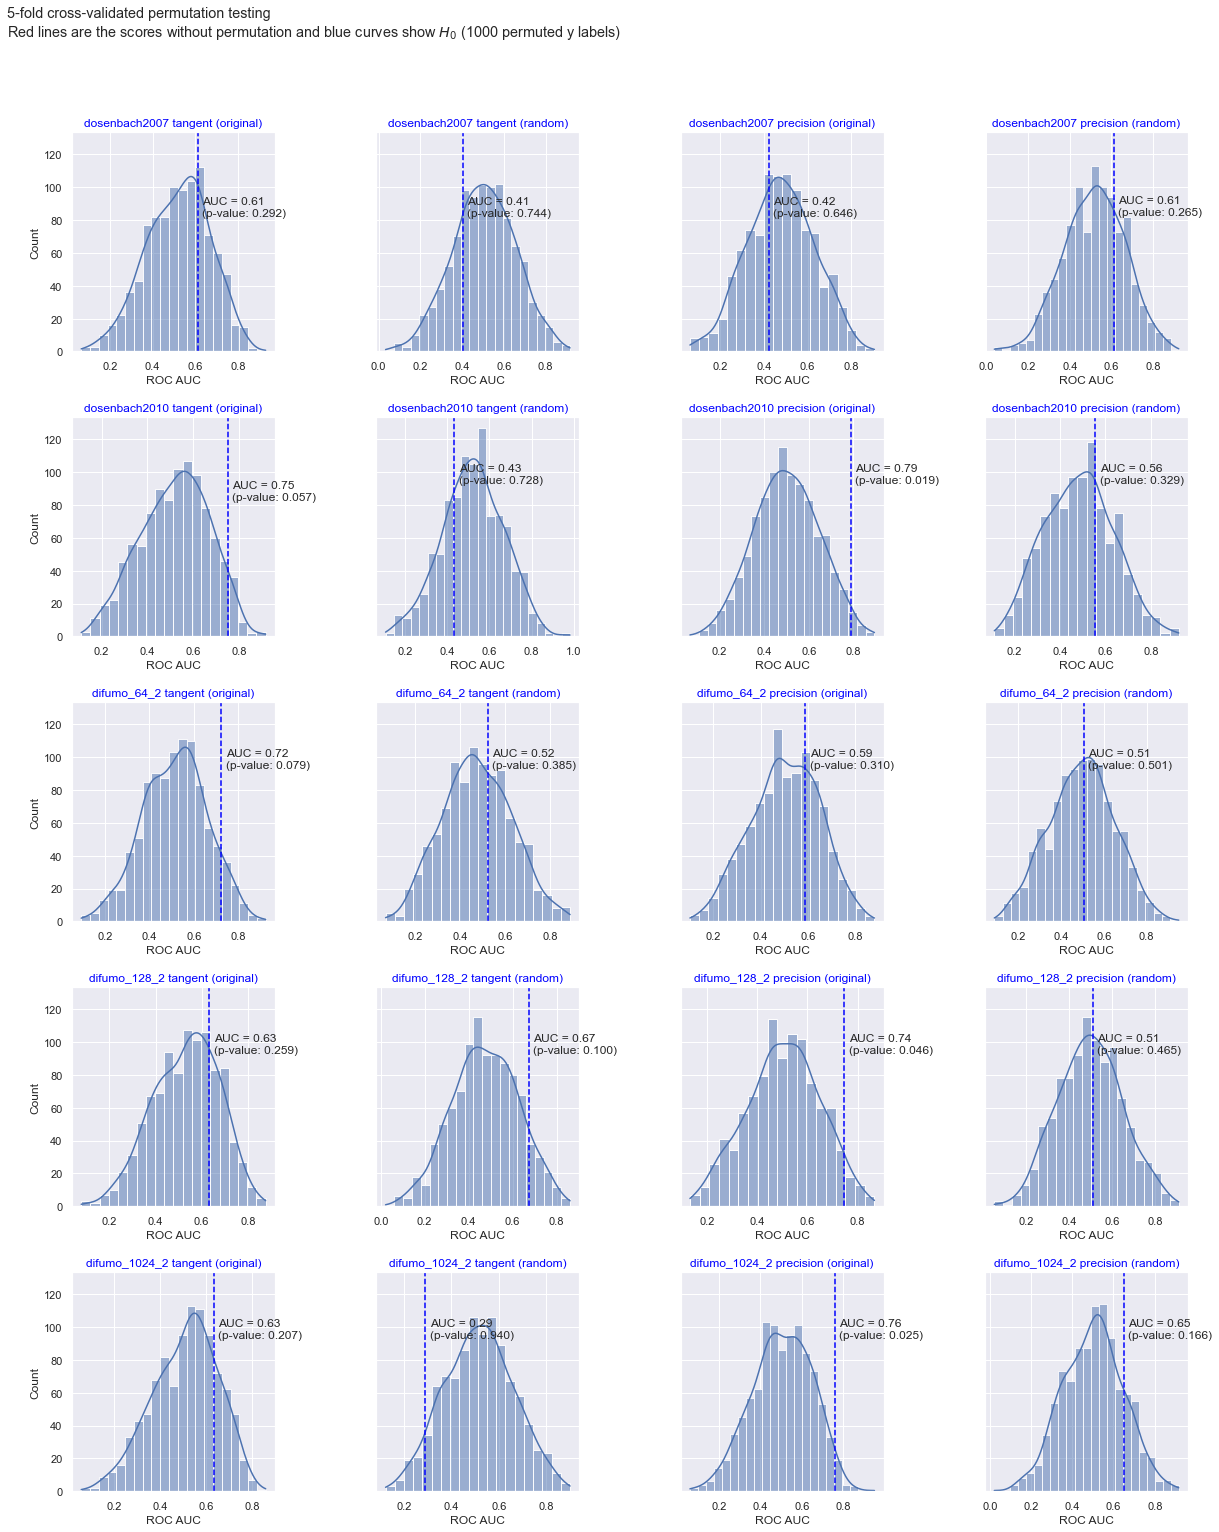

In [44]:
n_datasets = len(perm_results)

fig, axes = plt.subplots(math.ceil(n_datasets/4), 4, sharey=True,
                         figsize=(20, 5 * math.ceil(n_datasets/4)),
                         gridspec_kw=dict(wspace=.5, hspace=.3))

for i, atlas_name, is_rnd, conn_measure, obs_score, scores, p_value in perm_results.itertuples():
  ax = axes.flatten()[i]
  g = sns.histplot(scores, kde=True, ax=ax)
  
  
  ax.axvline(obs_score, ls='--', color='blue')

  ax.set(xlabel='ROC AUC')
  ax.text(x=obs_score + .02,
          y=ax.get_ylim()[1] * .7,
          s=f'AUC = {obs_score:.2f}\n(p-value: {p_value:.3f})')
  
  ax.set_title(f'{atlas_name} {conn_measure} '
               f'({"random" if is_rnd else "original"})', color='blue')

plt.suptitle('5-fold cross-validated permutation testing\n'
             'Red lines are the scores without permutation '
             f'and blue curves show $H_0$ ({len(scores)} permuted y labels)',
             y=.95, x=.08, ha='left')
plt.show()

## FIXME: Permutation Importance

In [ ]:
%%script echo skipping

from sklearn.inspection import permutation_importance

pipe.fit(X, y)
perm_imp_result = permutation_importance(pipe, X, y, 
                                         n_repeats=100,
                                         scoring='roc_auc', n_jobs=-1)

perm_sorted_idx = perm_imp_result.importances_mean.argsort()

# sns.boxplot(
#     result.importances[perm_sorted_idx].T,
#     vert=False,
#     labels=data.feature_names[perm_sorted_idx],
# )


perm_imp_result.importances[perm_sorted_idx]

In [ ]:
%%script echo skipping

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 10))

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90
)

dendro_idx = np.arange(0, len(dendro["ivl"]))



ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [ ]:
%%script echo skipping

from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_clustered = X[:, selected_features]

# Permmutation Importance

from sklearn.inspection import permutation_importance

grid.fit(X_clustered[train], y[train])
perm_imp_result = permutation_importance(grid, X_clustered[test], y[test],
                                         scoring='roc_auc',
                                         n_repeats=100)

sorted_idx = perm_imp_result.importances_mean.argsort()[::-1][:10][::-1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot(
    perm_imp_result.importances[sorted_idx].T,
    labels = feature_names[np.array(selected_features)[sorted_idx]],
    vert=False,
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()